<table>
    <tr>
        <td>
            <img src="extra/logo_scgis.png" width="100" height="100" />
        </td>
        <td>
        <img src="extra/nansen_logo.png" width="150" height="150" />
        </td>
        <td>
            <center>
                <font size = 1>
                27-28 ОКТЯБРЯ 2017, САНКТ-ПЕТЕРБУРГ, УНИВЕРСИТЕТ ИТМО<br>
                КОНФЕРЕНЦИЯ СООБЩЕСТВА ПРИРОДООХРАННЫХ ГИС В РОССИИ<br><br>
                </font>
                <font size = 3>
                Материалы к мастер-классу<br> <b>Программирование тематических алгоритмов обработки ДДЗЗ</b><br><br>
                </font>
                <font size = 2>
                <b>Эдуард Казаков</b><br>
                Международный центр по окружающей среде и дистанционному зондированию им. Нансена
                </font>
            </center>
        </td>
    </tr>
</table>

<center>
<b>Часть 4. Полноценная задача: моделирование поля температур и картографирование аномалий</b>
</center>

Landsat 8 осуществляет зондирование в том числе в диапазонах длин волн, соответствующих собственному тепловому излучению поверхности земли (каналы 10, 11, сенсор TIRS). Однако восстановление реальных физических температур - нетривальная задача, решаемая с привлечением в том числе атмосферных моделей.

Есть при этом упрощенная модель, позволяющая с компромиссной достоверностью восстанавливать температуры без привлечения внешних данных, построенная на линейной цепочке вычислений - а значит, автоматизируемая.

Опуская детали, приведем конечную формулу для расчёта физической температуры поверхности:

<img src="extra/plank.png" width="200" />

Здесь Ts - физическая температура в Кельвинах (искомое), TB - яркостная температура, λ - центральная длина волны теплового сенсора, p - константа, e - излучательная способность поверхности.

Разберёмся со всеми компонентами отдельно.

TB - яркостная температура, вычисляется непосредственно из значений пикселя в канале 10 или 11. Рассчитывается по формуле

<img src="extra/brightness_temp_formula.png" width="200" />

Где K1 и K2 - коэффициенты из метаданных, R - спектральная яркость, рассчитываемая в процессе радиометрической калибровки (см. часть 2)

λ - Центральная длина волны в соответствии с таблицей

<table>
    <tr>
        <td>
            Satellite
        </td>
        <td>
            Band
        </td>
        <td>
            λ(µm)
        </td>
    </tr>
    <tr>
        <td>
            Landsat 4, 5, and 7
        </td>
        <td>
            6
        </td>
        <td>
            11.45
        </td>
    </tr>
    <tr>
        <td>
            Landsat 8
        </td>
        <td>
            10
        </td>
        <td>
            10.8
        </td>
    </tr>
    <tr>
        <td>
            Landsat 8
        </td>
        <td>
            11
        </td>
        <td>
            12
        </td>
    </tr>
</table>


с2 - константа. c2 = h∗c/s

где h - Постоянная Планка (6.626∗10−34)

s - Постоянная Больцмана (1.38∗10−23)

c - скорость света (2.998∗10 8)

И наконец e - излучательная способность поверхности (LSE). Дело в том, что у разных материалов различная связь между радиационной температурой (фиксируемой сенсором) и физической. Для получения этого параметра можно использовать карту типов земель, либо воспользоваться одним из упрощенных методов. Например, описан способ, грубо определяющий излучательную способность в зависимости от значения NDVI:

ndvi_value > 0.727: return 0.990

(ndvi_value >= 0.157) and (ndvi_value <= 0.727): return 1.0094 + 0.047*math.log(ndvi_value)

(ndvi_value >= -0.185) and (ndvi_value < 0.157): return 0.970

ndvi_value < -0.185 : return 0.995

Таким образом шаги по восстановлению поля физических температур следующие:
1. Радиометрическая калибровка каналов 4,5, 11
2. Расчёт NDVI по откалиброванным каналам 4, 5
3. Расчёт яркостной температуры по откалиброванному каналу 11
4. Пересчёт NDVI в LSE
5. Расчёт температуры упрощенной моделью


Реализуем функции, которые нам помогут всё это считать. Организуем процесс так, чтобы названия файлов для открытия брались автоматически по метаданным.

In [1]:
# Импорт всех библиотек, которые могут нам понадобиться

from osgeo import gdal

import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np
import math


from IPython.display import Image
from metadata_reader import LandsatMetadata

mpl.rcParams['figure.figsize'] = (10,10)

from metadata_reader import LandsatMetadata

In [10]:
def get_red_radiance_as_array (metadata):
    red_dn = gdal.Open(metadata.red_channel_path)
    red_dn_array = np.array(red_dn.GetRasterBand(1).ReadAsArray().astype(np.float16))
    red_dn_array[red_dn_array==0]=[np.nan]
    print 'calculating red channel radiance...'
    red_radiance_array = metadata.red_channel_mult * red_dn_array + metadata.red_channel_add
    return red_radiance_array
        
def get_nir_radiance_as_array (metadata):
    nir_dn = gdal.Open(metadata.nir_channel_path)
    nir_dn_array = np.array(nir_dn.GetRasterBand(1).ReadAsArray().astype(np.float16))
    nir_dn_array[nir_dn_array==0]=[np.nan]
    print 'calculating NIR channel radiance...'
    nir_radiance_array = metadata.nir_channel_mult * nir_dn_array + metadata.nir_channel_add
    return nir_radiance_array
        
def get_red_reflectance_as_array (metadata):
    red_radiance = get_red_radiance_as_array(metadata)
    print 'calculating red channel reflectance...'
    red_reflectance = (math.pi * red_radiance * (metadata.earth_sun_distance**2))/(metadata.red_channel_solar_irradiance * math.sin(metadata.sun_elevation))
    return red_reflectance

def get_nir_reflectance_as_array (metadata):
    nir_radiance = get_nir_radiance_as_array(metadata)
    print 'calculating NIR channel reflectance...'
    nir_reflectance = (math.pi * nir_radiance * (metadata.earth_sun_distance**2))/(metadata.nir_channel_solar_irradiance * math.sin(metadata.sun_elevation))
    return nir_reflectance
 
def get_ndvi_as_array (metadata):
    red_reflectance = get_red_reflectance_as_array(metadata)
    nir_reflectance = get_nir_reflectance_as_array(metadata)
    print 'calculating NDVI...'
    ndvi = (nir_reflectance - red_reflectance) / (nir_reflectance + red_reflectance)
    return ndvi
        
    
def convert_ndvi_to_lse (ndvi_value):
    if ndvi_value > 0.727:
        return 0.990
    elif (ndvi_value >= 0.157) and (ndvi_value <= 0.727):
        return 1.0094 + 0.047*math.log(ndvi_value)
    elif (ndvi_value >= -0.185) and (ndvi_value < 0.157):
        return 0.970
    else:
        return 0.995
            
def get_emissivity_from_ndvi_as_array (metadata):
    np_convert_ndvi_to_lse = np.vectorize(convert_ndvi_to_lse)
    ndvi = get_ndvi_as_array(metadata)
    print 'calculating land surface emissivity...'
    lse = np_convert_ndvi_to_lse(ndvi)    
    return lse
        
        
def get_thermal_radiance_as_array (metadata):
    thermal_dn = gdal.Open(metadata.thermal_channel_path)
    thermal_dn_array = np.array(thermal_dn.GetRasterBand(1).ReadAsArray().astype(np.int16))
    print 'calculating thermal channel radiance...'
    thermal_radiance_array = metadata.thermal_channel_mult * thermal_dn_array + metadata.thermal_channel_add
    return thermal_radiance_array
        
def get_brightness_temperature_as_array (metadata):
    thermal_radiance = get_thermal_radiance_as_array(metadata)
    print 'calculating brightness temperature...'
    brightness_temperature = (metadata.thermal_k2 / np.log(metadata.thermal_k1 / thermal_radiance + 1))
    return brightness_temperature

def get_surface_temperature_simplified_model (metadata):
    p = 14380 # from planck, boltzman and light velocity
    def calculate_lst_simple (brightness_temperature, lse, wavelength):    
        return ( brightness_temperature / ( 1 + ((wavelength * brightness_temperature / p) * math.log(lse)) ) ) - 273.15
        
    np_calculate_lst_simple = np.vectorize(calculate_lst_simple)
            
    lse = get_emissivity_from_ndvi_as_array(metadata)
    brightness_temperature = get_brightness_temperature_as_array(metadata)
    wavelength = metadata.thermal_wavelength
    print 'calculating land surface temperature (simplified model [Weng, et al. 2004])...'
        
    lst = np_calculate_lst_simple(brightness_temperature, lse, wavelength)
    return lst

Всё, нужная нам математика реализована в функциях выше. Разберем, что будет происходить с запуском главной функции get_surface_temperature_simplified_model:

На вход она получает метаданные. Запускает функцию расчёта LSE, которая в свою очередь запускает функции расчета NDVI (а для это сначала считаются отражательные способности, опять же по метаданным).

Затем происходит расчёт яркостных температур, и, наконец, применение первой формулы к исходной сцене

Попробуем посчитать!

In [6]:
metadata = LandsatMetadata('/home/silent/Writing/workshops/data/LC08_L1TP_174029_20170917_20170929_01_T1/LC08_L1TP_174029_20170917_20170929_01_T1_MTL.txt','Landsat_8')

reading metadata...


In [8]:
print metadata.red_channel_path
print metadata.nir_channel_path

/home/silent/Writing/workshops/data/LC08_L1TP_174029_20170917_20170929_01_T1/LC08_L1TP_174029_20170917_20170929_01_T1_B4.TIF
/home/silent/Writing/workshops/data/LC08_L1TP_174029_20170917_20170929_01_T1/LC08_L1TP_174029_20170917_20170929_01_T1_B5.TIF


In [11]:
lst = get_surface_temperature_simplified_model(metadata)

calculating red channel radiance...
calculating red channel reflectance...
calculating NIR channel radiance...
calculating NIR channel reflectance...
calculating NDVI...


/home/silent/anaconda2/envs/mainenv/lib/python2.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in subtract
/home/silent/anaconda2/envs/mainenv/lib/python2.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in divide


calculating land surface emissivity...
calculating thermal channel radiance...
calculating brightness temperature...


/home/silent/anaconda2/envs/mainenv/lib/python2.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in log


calculating land surface temperature (simplified model [Weng, et al. 2004])...


In [12]:
lst

array([[-131.3953714, -131.3953714, -131.3953714, ..., -131.3953714,
        -131.3953714, -131.3953714],
       [-131.3953714, -131.3953714, -131.3953714, ..., -131.3953714,
        -131.3953714, -131.3953714],
       [-131.3953714, -131.3953714, -131.3953714, ..., -131.3953714,
        -131.3953714, -131.3953714],
       ..., 
       [-131.3953714, -131.3953714, -131.3953714, ..., -131.3953714,
        -131.3953714, -131.3953714],
       [-131.3953714, -131.3953714, -131.3953714, ..., -131.3953714,
        -131.3953714, -131.3953714],
       [-131.3953714, -131.3953714, -131.3953714, ..., -131.3953714,
        -131.3953714, -131.3953714]])

In [15]:
lst [lst < -100] = np.nan

/home/silent/anaconda2/envs/mainenv/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


In [16]:
lst

array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       ..., 
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]])

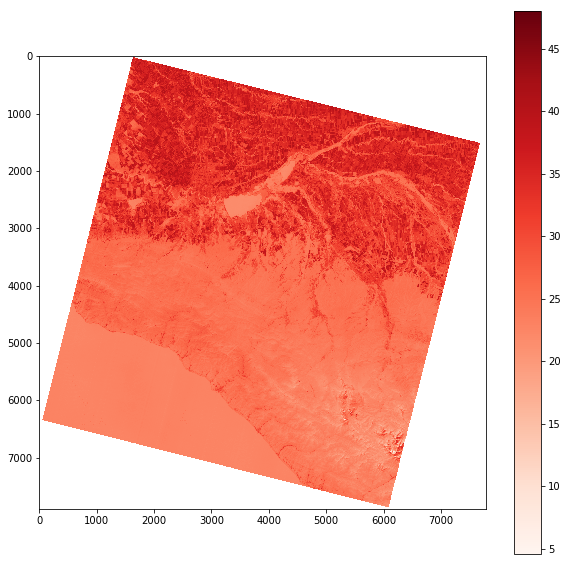

In [54]:
plt.imshow(lst,cmap='Reds')
plt.colorbar()
plt.show()

In [21]:
lst[4500,4500]

24.797681291313381

In [32]:
size = 32
step = size
subimages = []
for r in range(0, lst.shape[0]-size+1, step):
    row_subimages = [lst[r:r+size, c:c+size] for c in range(0, lst.shape[1]-size+1, step)]
    subimages.append (row_subimages)
subimages = np.array(subimages)

In [33]:
subimages.shape

(246, 243, 32, 32)

In [63]:
size = 100
step = size
subimages = []
for r in range(0, lst.shape[0]-size+1, step):
    row_subimages = [np.max(lst[r:r+size, c:c+size])-(np.min(lst[r:r+size, c:c+size])) for c in range(0, lst.shape[1]-size+1, step)]
    #row_subimages = [np.nanmax(lst[r:r+size, c:c+size]) for c in range(0, lst.shape[1]-size+1, step)]
    subimages.append (row_subimages)
subimages = np.array(subimages)

In [64]:
subimages.shape

(78, 77)

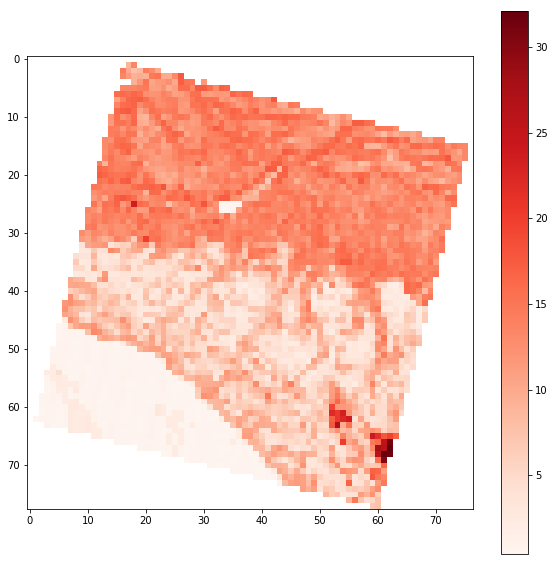

In [65]:
plt.imshow(subimages, cmap='Reds')
plt.colorbar()
plt.show()

In [41]:
subimages[100,100]

0.0

In [45]:
np.nanstd(subimages)

4.1624328296245379

In [47]:
np.nanmean(subimages)

5.6126570693327755

In [48]:
np.nanmin(subimages)

0.0

In [49]:
np.nanmax(subimages)

31.458474430689876